In [1]:
%matplotlib notebook
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

<IPython.core.display.Javascript object>


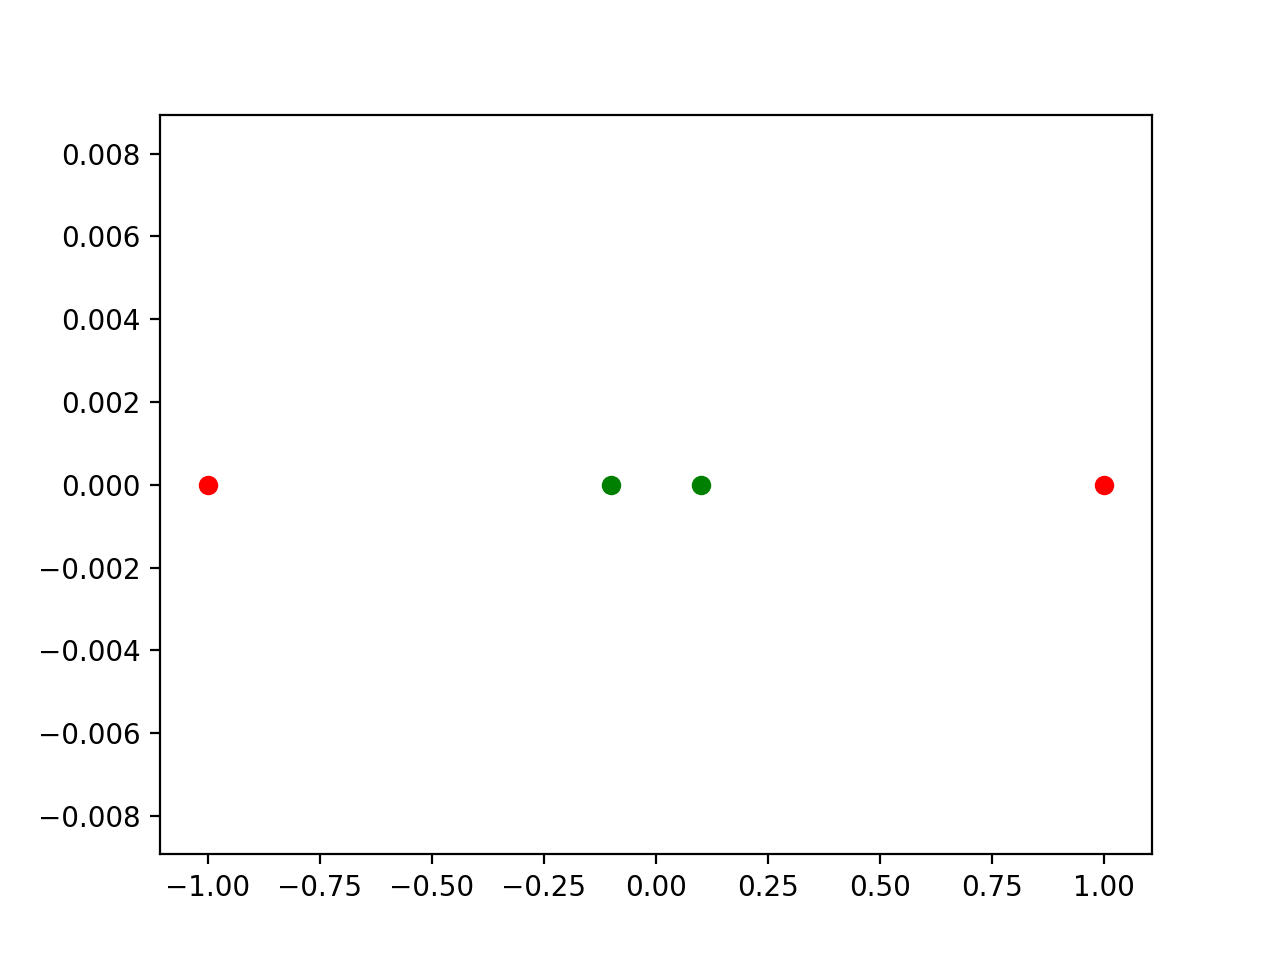

In [2]:
random.seed(3)

def rand_cluster(n,c,r):
    """returns n random points in disk of radius r centered at c"""
    x = c
    points = []
    for i in range(n):
        theta = 2*math.pi*random.random()
        s = r*random.random()
        points.append([x+s*math.cos(theta)])
    return points

def rand_clusters(k,n,r, a,b,c,d):
    """return k clusters of n points each in random disks of radius r
    where the centers of the disk are chosen randomly in [a,b]x[c,d]"""
    clusters = []
    for _ in range(k):
        x = a + (b-a)*random.random()
        y = c + (d-c)*random.random()
        clusters.extend(rand_cluster(n,x,r))
    return clusters

n = 2
X = rand_clusters(2,n,0.8,-1,1,-1,1)
data = np.array(X)
label = np.transpose(np.array([[1]*n + [0]*n]))

# label = np.array([1]*n + [0]*n)
data = []
label = []
data.append([-1])
data.append([1])
data.append([0.1])
data.append([-0.1])
label.append([1])
label.append([1])
label.append([0])
label.append([0])
data = np.array(data)
label = np.array(label)

fig = plt.figure()
plt.scatter(data[:n], [0]*n, color=['red'])
plt.scatter(data[n:], [0]*n, color=['green'])
plt.show()
plt.savefig('report1/data1.eps', format='eps')

In [ ]:
n = 10
data = []
label = []
data.append([-1])
data.append([-.8])
data.append([-0.6])
data.append([-0.4])
data.append([-0.2])
data.append([0.2])
data.append([0.4])
data.append([0.6])
data.append([0.8])
data.append([1.0])

data.append([-0.9])
data.append([-0.7])
data.append([-0.5])
data.append([-0.3])
data.append([-0.1])
data.append([0.1])
data.append([0.3])
data.append([0.5])
data.append([0.7])
data.append([0.9])

label.append([1])
label.append([1])
label.append([1])
label.append([1])
label.append([1])
label.append([1])
label.append([1])
label.append([1])
label.append([1])
label.append([1])

label.append([0])
label.append([0])
label.append([0])
label.append([0])
label.append([0])
label.append([0])
label.append([0])
label.append([0])
label.append([0])
label.append([0])
data = np.array(data)
label = np.array(label)
# print (data, label)

fig = plt.figure()
plt.scatter(data[:n], [0]*n, color=['red'])
plt.scatter(data[n:], [0]*n, color=['green'])
plt.show()
plt.savefig('report1/data2.eps', format='eps')

In [3]:
tf.reset_default_graph()

# def weight_variable(shape, name):
#     initial = tf.truncated_normal(shape=shape, stddev=0.1)
#     return tf.get_variable(name=name, initializer=initial)

# def bias_variable(shape, name):
#     initial = tf.constant(0.1, shape=shape)
#     return tf.get_variable(name=name, initializer=initial)


x = tf.placeholder(tf.float32, [None, 1])
y_ = tf.placeholder(tf.float32, [None, 1])


n_input = 1
n_hidden = 2
n_output = 1
lmd = 0


rang = 1.
# parameters = tf.Variable(tf.concat([#tf.truncated_normal([n_input * n_hidden]), 
#                                     tf.random_uniform([7], minval= -rang, maxval= rang, seed=2),
#                                    ], 0))
parameters = tf.Variable(tf.concat([tf.truncated_normal([n_input * n_hidden], seed=1), tf.zeros([n_hidden]),\
                                    tf.truncated_normal([n_hidden * n_output], seed=2), tf.zeros([n_output]),\
                                   ], 0))

idx_from = 0 
weights1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_input*n_hidden]), [n_input, n_hidden])
idx_from = idx_from + n_input*n_hidden
biases1 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden]), [n_hidden])
hidden = tf.nn.sigmoid(tf.matmul(x, weights1) + biases1)

idx_from = idx_from + n_hidden
weights2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_hidden*n_output]), [n_hidden, n_output])
idx_from = idx_from + n_hidden*n_output
biases2 = tf.reshape(tf.slice(parameters, begin=[idx_from], size=[n_output]), [n_output])
y = tf.nn.sigmoid(tf.matmul(hidden, weights2) + biases2)

loss = tf.reduce_mean(tf.reduce_sum(tf.pow(y_ - y, 2), reduction_indices=[1])) #I also tried simply tf.nn.l2_loss(y_ - y)

lr = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
grads_and_vars = optimizer.compute_gradients(loss)
grad = tf.gradients(loss, parameters)
hess = tf.hessians(loss, parameters)
train_step = optimizer.apply_gradients(grads_and_vars)

In [4]:
def cg(A, b, it, x=None):
#     A: 2d numpy.array of positive semi-definite (symmetric) matrix
#     b: 1d numpy.array
#     x: 1d numpy.array of initial point

    A = np.array(A)
    b = np.array(b)
#     print (A, b)
    n = len(b)
    if not x:
        x = np.ones(n)
    r = np.dot(A, x) - b
    p = - r
    r_k_norm = np.dot(r, r)
    for i in range(it):
        Ap = np.dot(A, p)
        alpha = r_k_norm / np.dot(p, Ap)
        if alpha < 0:
#             print ('Neg Itr:', i)
            return p, it
        x += alpha * p
        r += alpha * Ap
        r_kplus1_norm = np.dot(r, r)
        beta = r_kplus1_norm / r_k_norm
        r_k_norm = r_kplus1_norm
        if r_kplus1_norm < 1e-5:
#             print ('Itr:', i)
            break
        p = beta * p - r
    return x, -1

In [5]:
def get_accuracy(predy):
    match = [(predy[i] - 0.5) * (label[i] - 0.5) > 0  for i in range(n*2)]
    acc = sum(match)*1./2/n
    return acc[0]

def get_norm_grad(grad):
    nng = 0.
    for g in grad:
        nng += np.linalg.norm(g) ** 2
    return np.sqrt(nng)
    
     
def displayH(a):
    a = np.array(a[0])
#     print ("Matrix["+("%d" %a.shape[0])+"]["+("%d" %a.shape[1])+"]")
    rows = a.shape[0]
    cols = a.shape[1]
    for i in range(0, rows):
        for j in range(0, cols):
            print("%0.2g " %a[i,j], end="")
        print ()
    print ()

In [6]:
sess = tf.InteractiveSession()
dic = {}
nr = 200
cgIt = 1
stepsize = [1e1, 1e-0, 1e-1, 1e-2]

rts = []
for r in range(nr):
    
    tf.global_variables_initializer().run()
    v0, g, H, w = sess.run([loss, grad, hess, parameters], feed_dict={x: data, y_: label})    
    w0 = w
    
    d, status = cg(H[0], g[0], cgIt)

    ss = 10.
    if status > 0:
        while True:
            w_cg = w0 - ss * d
            v_cg = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_cg})    
            if v_cg > v0:
                ss = -ss * 0.5
            else:
                break
    else:
        while True:
            w_cg = w0 - ss * d
            v_cg = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_cg})    
            if v_cg > v0:
                ss = -ss * 0.5
            else:
                break
  
    ss = 10.
    while True:
        w_gd = w0 - ss * g[0]
        v_gd = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_gd})    
        if v_gd > v0:
            ss = ss * 0.5
        else:
            break

#     vl = []
#     for ss in stepsize:
#         w_gd = w0 - ss * g[0]
#         v_gd = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_gd})    
#         vl.append(v_gd)
#     v_gd = min(vl)
    
    rt = (v_gd-v0) / (v_cg-v0)
    rts.append(rt)
#     print (rt)
    

sess.close() 

In [7]:
count = 0
for i in rts:
    if i > 1:
        count += 1
        
print (count/nr)

0.355


<IPython.core.display.Javascript object>


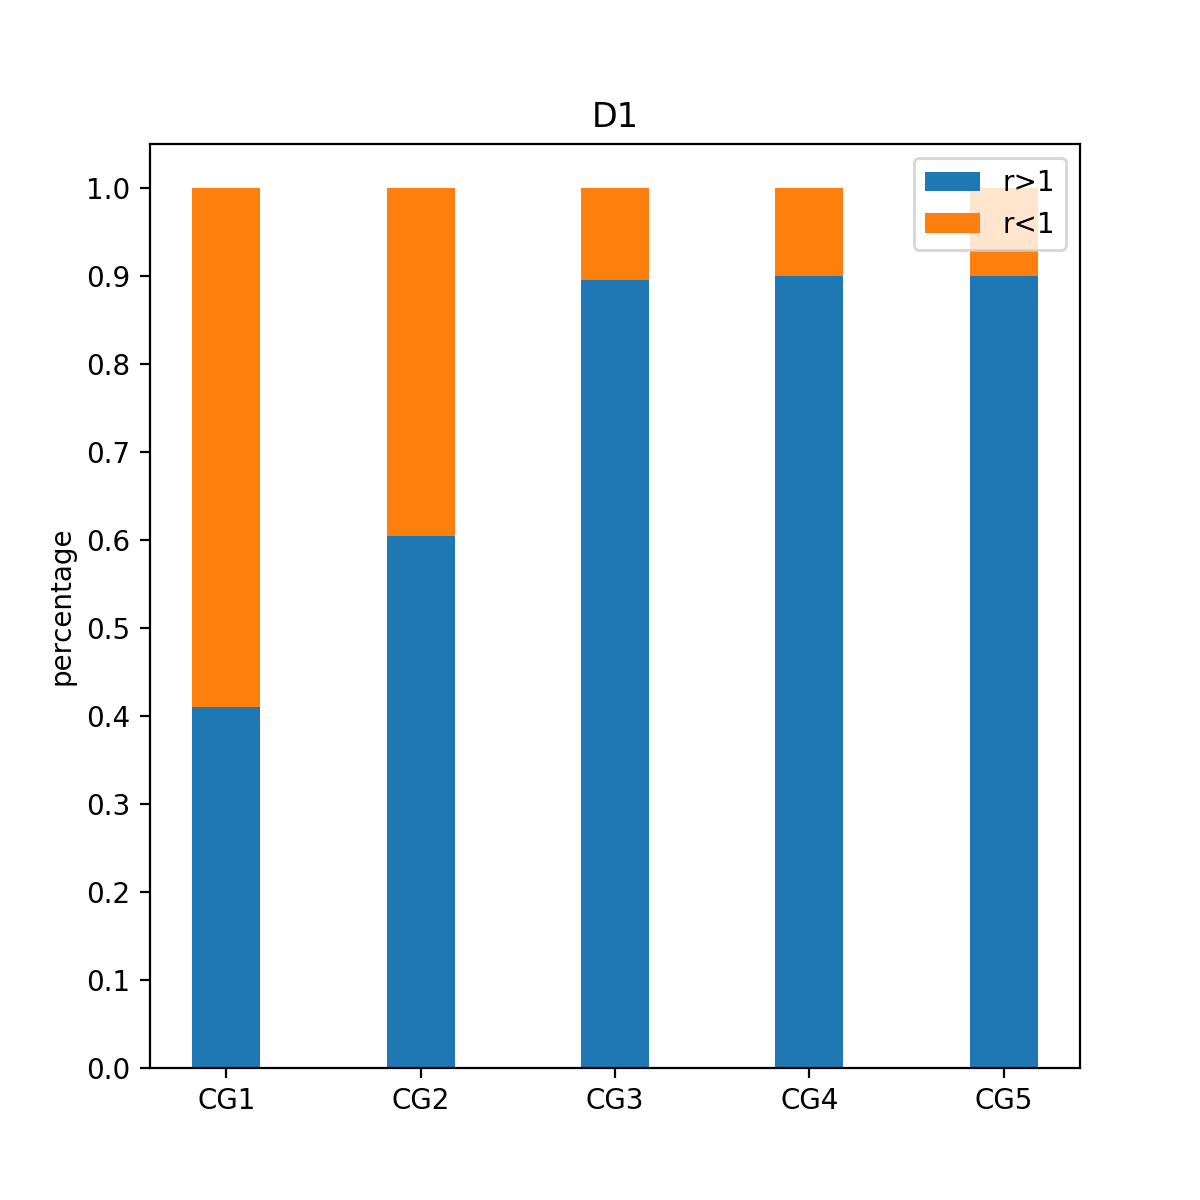

In [8]:
N = 5
menMeans = (0.385, 0.48, 0.835, 0.845, 0.845)
womenMeans = (0.615, 0.52, 0.165, 0.155, 0.155)

menMeans = (0.41, 0.605, 0.895, 0.9, 0.9)
womenMeans = (0.59, 0.395, 0.105, 0.1, 0.1)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


fig = plt.figure(figsize=(6,6))
p1 = plt.bar(ind, menMeans, width)
p2 = plt.bar(ind, womenMeans, width, bottom=menMeans)

plt.ylabel('percentage')
plt.title('D1')
plt.xticks(ind, ('CG1', 'CG2', 'CG3', 'CG4', 'CG5'))
plt.yticks(np.arange(0,1.1,0.1))
plt.legend((p1[0], p2[0]), ('r>1', 'r<1'))

plt.show()
plt.savefig('report1/CGD.eps', format='eps')

In [9]:
sess = tf.InteractiveSession()
dic = {}
nr = 200
cgIt = 1
stepsize = [1e1, 1e-0, 1e-1, 1e-2]

rts = []
for r in range(nr):
    
    tf.global_variables_initializer().run()
    v0, g, H, w = sess.run([loss, grad, hess, parameters], feed_dict={x: data, y_: label})    
    w0 = w
    
    d, status = cg(H[0], g[0], cgIt)

    eig,eigvec = np.linalg.eig(H[0])
    leftmost = eigvec[np.argmin(eig)]
    ss = 1.
    if min(eig) < 0:
        while True:
            w_cg = w0 - ss * leftmost
            v_cg = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_cg})    
            if v_cg >= v0:
                ss = -ss * 0.5
            else:
                break
    else:
        while True:
            w_cg = w0 - ss * d
            v_cg = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_cg})    
            if v_cg >= v0:
                ss = -ss * 0.5
            else:
                break
  
    ss = 1.
    while True:
        w_gd = w0 - ss * g[0]
        v_gd = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_gd})    
        if v_gd > v0:
            ss = ss * 0.5
        else:
            break
    
    rt = (v_gd-v0) / (v_cg-v0)
    rts.append(rt)
#     print (min(eig), eig, rt)
    

sess.close() 

In [10]:
count = 0
for i in rts:
    if i > 1:
        count += 1
        
print (count/nr)

0.215


In [11]:
sess = tf.InteractiveSession()
dic = {}
nr = 10
ni = 100
cgIt = 5
stepsize = [1e1, 1e-0, 1e-1, 1e-2]

rts = []
for r in range(nr):
    
    print (r)

    tf.global_variables_initializer().run()
    v0, g, H, pd, w0 = sess.run([loss, grad, hess, y, parameters], feed_dict={x: data, y_: label})    
    dic[r] = {'w0': w0}    
    nng = get_norm_grad(g)
    acc = get_accuracy(pd)*100
    eig = sorted(np.linalg.eigvals(H)[0])
    print("Init: Iter {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g},nnw {:.4g}, low_eig {:.4g}."\
            .format(0, acc, v0, nng, np.linalg.norm(w0[:]), min(eig) ))
    
    w_cg = w0
    dic[r]['cg'] = {'v':[], 'nng':[], 'acc':[], 'emin':[]}
    for i in range(ni):
        vOld, g, H, pd, wOld= sess.run([loss, grad, hess, y, parameters], feed_dict={x: data, y_: label, parameters: w_cg})    
        d, status = cg(H[0], g[0], cgIt)
        ss = 10.
        while True:
            w_cg = wOld - ss * d
            v_cg = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_cg})    
            if v_cg >= vOld and np.abs(ss)>1e-5:
                ss = -ss * 0.5
            else:
                break
        vOld, g, H, pd, wOld= sess.run([loss, grad, hess, y, parameters], feed_dict={x: data, y_: label, parameters: w_cg})    
        nng = get_norm_grad(g)
        acc = get_accuracy(pd)*100
        eig,eigvec = np.linalg.eig(H[0])
        dic[r]['cg']['v'].append(vOld) 
        dic[r]['cg']['nng'].append(nng)
        dic[r]['cg']['acc'].append(acc)
        dic[r]['cg']['emin'].append(min(eig))
    print("CG: Iter {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g},nnw {:.4g}, low_eig {:.4g}."\
            .format(i+1, acc, vOld, nng, np.linalg.norm(wOld[:]), min(eig) ))

    
    
    w_nc = w0
    dic[r]['nc'] = {'v':[], 'nng':[], 'acc':[], 'emin':[]}
    for i in range(ni):
        vOld, g, H, pd, wOld= sess.run([loss, grad, hess, y, parameters], feed_dict={x: data, y_: label, parameters: w_nc})    
        eig,eigvec = np.linalg.eig(H[0])
        leftmost = eigvec[np.argmin(eig)]
        ss = 10.
        while True:
            w_nc = wOld - ss * leftmost
            v_nc = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_nc})    
            if v_nc >= vOld and np.abs(ss)>1e-4:
                ss = -ss * 0.5
            else:
                break
        vOld, g, H, pd, wOld = sess.run([loss, grad, hess, y, parameters], feed_dict={x: data, y_: label, parameters: w_nc})    
        nng = get_norm_grad(g)
        acc = get_accuracy(pd)*100
        eig,eigvec = np.linalg.eig(H[0])
        dic[r]['nc']['v'].append(vOld) 
        dic[r]['nc']['nng'].append(nng)
        dic[r]['nc']['acc'].append(acc)
        dic[r]['nc']['emin'].append(min(eig))
    print("NC: Iter {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g},nnw {:.4g}, low_eig {:.4g}."\
        .format(i+1, acc, vOld, nng, np.linalg.norm(wOld[:]), min(eig) ))

    w_gd = w0
    dic[r]['gd'] = {'v':[], 'nng':[], 'acc':[], 'emin':[]}
    for i in range(ni):
        vOld, g, wOld= sess.run([loss, grad, parameters], feed_dict={x: data, y_: label, parameters: w_gd})    
        ss = 10.
        while True:
            w_gd = wOld - ss * g[0]
            v_gd = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_gd})    
#                 print (v_nc)
            if v_gd >= vOld and np.abs(ss)>1e-4:
                ss = -ss * 0.5
            else:
                break
        vOld, g, H, pd, wOld= sess.run([loss, grad, hess, y, parameters], feed_dict={x: data, y_: label, parameters: w_gd})    
        nng = get_norm_grad(g)
        acc = get_accuracy(pd)*100
        eig,eigvec = np.linalg.eig(H[0])
        dic[r]['gd']['v'].append(vOld) 
        dic[r]['gd']['nng'].append(nng)
        dic[r]['gd']['acc'].append(acc)
        dic[r]['gd']['emin'].append(min(eig))
    print("GD: Iter {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g},nnw {:.4g}, low_eig {:.4g}."\
        .format(i+1, acc, vOld, nng, np.linalg.norm(wOld[:]), min(eig) ))





sess.close() 

0
Init: Iter 0, accuracy 50.00%, loss 0.266699, nng 0.07339,nnw 1.907, low_eig -0.01417.
CG: Iter 100, accuracy 50.00%, loss 0.258469, nng 0.0541,nnw 1.53, low_eig -0.01065.
NC: Iter 100, accuracy 75.00%, loss 0.168859, nng 0.002218,nnw 21.43, low_eig -1.482e-05.
GD: Iter 100, accuracy 100.00%, loss 0.017075, nng 0.006793,nnw 13, low_eig 0.0008988.
1
Init: Iter 0, accuracy 50.00%, loss 0.258095, nng 0.04704,nnw 1.879, low_eig -0.01452.
CG: Iter 100, accuracy 50.00%, loss 0.253426, nng 0.03459,nnw 1.22, low_eig -0.006533.
NC: Iter 100, accuracy 75.00%, loss 0.215822, nng 0.03305,nnw 7.825, low_eig -0.005197.
GD: Iter 100, accuracy 100.00%, loss 0.005040, nng 0.002944,nnw 12.94, low_eig 0.0003971.
2
Init: Iter 0, accuracy 50.00%, loss 0.250797, nng 0.01724,nnw 0.275, low_eig -0.003377.
CG: Iter 100, accuracy 50.00%, loss 0.250712, nng 0.01645,nnw 0.2839, low_eig -0.00316.
NC: Iter 100, accuracy 50.00%, loss 0.250002, nng 0.0001495,nnw 0.4207, low_eig -0.000959.
GD: Iter 100, accuracy 25.

<IPython.core.display.Javascript object>


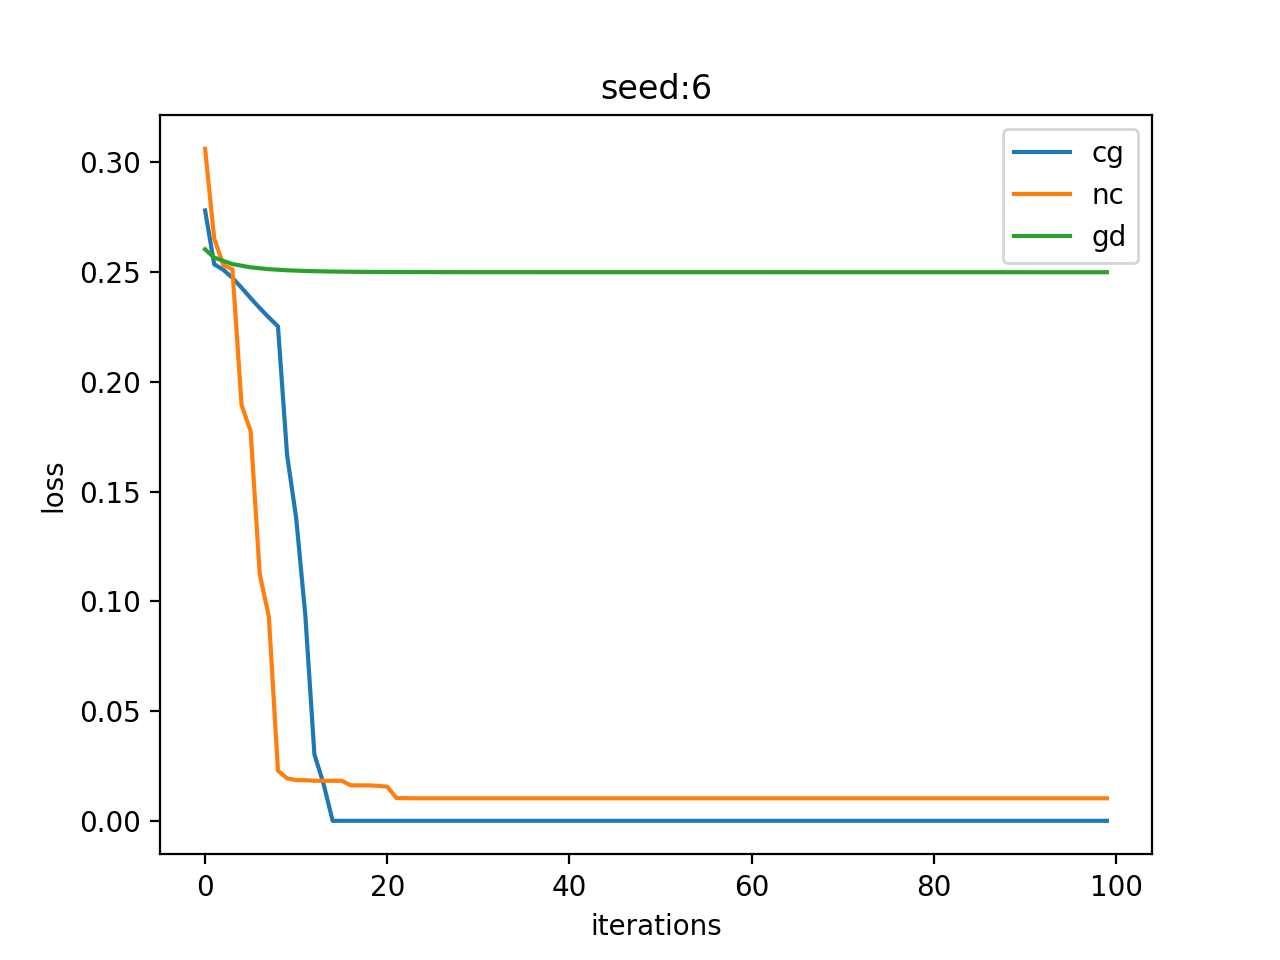

In [17]:
idx = 6
content = 'v'
lbs = {'v':'loss', 'nng':'norm of grad', 'emin': 'leftmost eigenvalue', 'acc':'accuracy'}

fig = plt.figure()
its = np.arange(0, ni, 1)
plt.plot(its, dic[idx]['cg'][content], label='cg')
plt.plot(its, dic[idx]['nc'][content], label='nc')
plt.plot(its, dic[idx]['gd'][content], label='gd')

leg = plt.legend(loc='best', ncol=1)
plt.title('seed:%1i' %(idx) )
plt.ylabel(lbs[content])
plt.xlabel('iterations')

plt.show()

In [16]:
sess = tf.InteractiveSession()

w_cg = dic[6]['w0']
for i in range(ni):
    vOld, g, H, pd, wOld= sess.run([loss, grad, hess, y, parameters], feed_dict={x: data, y_: label, parameters: w_cg})    
    d, status = cg(H[0], g[0], cgIt)
    ss = 10.
    while True:
        w_cg = wOld - ss * d
        v_cg = sess.run(loss, feed_dict={x: data, y_: label, parameters: w_cg})    
        if v_cg >= vOld and np.abs(ss)>1e-5:
            ss = -ss * 0.5
        else:
            break
    vOld, g, H, pd, wOld= sess.run([loss, grad, hess, y, parameters], feed_dict={x: data, y_: label, parameters: w_cg})    
    nng = get_norm_grad(g)
    acc = get_accuracy(pd)*100
    eig,eigvec = np.linalg.eig(H[0])
    print("CG: Iter {}, accuracy {:.2f}%, loss {:.6f}, nng {:.4g},nnw {:.4g}, low_eig {:.4g}."\
        .format(i+1, acc, vOld, nng, np.linalg.norm(wOld[:]), min(eig) ))




sess.close() 

CG: Iter 1, accuracy 50.00%, loss 0.278132, nng 0.09793,nnw 2.811, low_eig -0.01696.
CG: Iter 2, accuracy 75.00%, loss 0.253608, nng 0.03259,nnw 3.546, low_eig -0.01164.
CG: Iter 3, accuracy 75.00%, loss 0.251076, nng 0.03335,nnw 3.624, low_eig -0.00965.
CG: Iter 4, accuracy 75.00%, loss 0.247427, nng 0.03417,nnw 3.732, low_eig -0.007392.
CG: Iter 5, accuracy 75.00%, loss 0.242927, nng 0.03491,nnw 3.873, low_eig -0.005582.
CG: Iter 6, accuracy 75.00%, loss 0.238200, nng 0.03544,nnw 4.036, low_eig -0.004559.
CG: Iter 7, accuracy 75.00%, loss 0.233646, nng 0.03572,nnw 4.204, low_eig -0.003862.
CG: Iter 8, accuracy 75.00%, loss 0.229351, nng 0.03584,nnw 4.369, low_eig -0.003288.
CG: Iter 9, accuracy 75.00%, loss 0.225296, nng 0.03586,nnw 4.529, low_eig -0.00281.
CG: Iter 10, accuracy 75.00%, loss 0.166727, nng 0.1264,nnw 10.01, low_eig -0.02004.
CG: Iter 11, accuracy 100.00%, loss 0.137957, nng 0.1286,nnw 10.09, low_eig -0.03051.
CG: Iter 12, accuracy 100.00%, loss 0.093827, nng 0.09087,n

CG: Iter 97, accuracy 100.00%, loss 0.000000, nng 4.613e-09,nnw 39.36, low_eig 7.877e-14.
CG: Iter 98, accuracy 100.00%, loss 0.000000, nng 4.613e-09,nnw 39.36, low_eig 7.877e-14.
CG: Iter 99, accuracy 100.00%, loss 0.000000, nng 4.613e-09,nnw 39.36, low_eig 7.876e-14.
CG: Iter 100, accuracy 100.00%, loss 0.000000, nng 4.613e-09,nnw 39.36, low_eig 7.876e-14.
